In [11]:
import numpy as np
from scipy.interpolate import interp1d

import argopandas as argo
import bgcArgoDMQC as bgc
from deconv import deconv_master as deconv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

In [15]:
# grab floats with MTIME and DOXY measurements, load one
ix = argo.bio_prof.subset_parameter('MTIME').subset_parameter('DOXY')[400:401]
# ix = argo.float(6900890).bio_prof.subset_parameter('MTIME').subset_parameter('DOXY')
data = ix.levels[['MTIME', 'PRES', 'TEMP_DOXY', 'DOXY', 'DOXY_QC']]
data = data[data.MTIME.notna()]
data = data[data.DOXY.notna()]

# reverse all the arrays so they are forward in time rather than pressure, convert time to seconds
time  = (data.MTIME[::-1].values - data.MTIME.min())*60*60*24
obs   = data.DOXY[::-1].values
pres  = data.PRES[::-1].values
temp  = data.TEMP_DOXY[::-1].values
data

Reading 1 file                                                        


MTIME  \
file                                       N_PROF N_LEVELS             
coriolis/6900889/profiles/BR6900889_114.nc 1      0         0.001539   
                                                  1         0.001412   
                                                  2         0.001273   
                                                  3         0.001146   
                                                  4         0.001019   
...                                                              ...   
                                                  148      -0.222731   
                                                  149      -0.228958   
                                                  150      -0.234687   
                                                  151      -0.240336   
                                                  152      -0.246655   

                                                                   PRES  \
file                                       N_PROF N_LEVELS                
coriolis/6900889/profiles/BR6900889_114.nc 1      0            0.500000   
                                                  1            0.770000   
                                                  2            1.060000   
                                                  3            1.330000   
                                                  4            1.660000   
...                                                                 ...   
                                                  148       1750.619995   
                                                  149       1800.239990   
                                                  150       1850.060059   
                                                  151       1900.540039   
                                                  152       1950.520020   

                                                            TEMP_DOXY  \
file                                       N_PROF N_LEVELS              
coriolis/6900889/profiles/BR6900889_114.nc 1      0         25.649000   
                                                  1         25.646000   
                                                  2         25.641001   
                                                  3         25.636999   
                                                  4         25.646000   
...                                                               ...   
                                                  148        3.922000   
                                                  149        3.812000   
                                                  150        3.737000   
                                                  151        3.661000   
                                                  152        3.622000   

                                                                  DOXY DOXY_QC  
file                                       N_PROF N_LEVELS                      
coriolis/6900889/profiles/BR6900889_114.nc 1      0         203.920654    b'3'  
                                                  1         204.014725    b'3'  
                                                  2         203.943161    b'3'  
                                                  3         203.900574    b'3'  
                                                  4         203.985870    b'3'  
...                                                                ...     ...  
                                                  148       224.374298    b'3'  
                                                  149       228.267441    b'3'  
                                                  150       231.108261    b'3'  
                                                  151       232.877609    b'3'  
                                                  152       234.003677    b'3'  

[153 rows x 5 columns]

c:\Users\GordonC\Documents\projects\admt-doxy-correction\notebooks\dolvan-deconv-argo-test\deconv.py:642: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sigma == 'auto':
c:\Users\GordonC\Documents\projects\admt-doxy-correction\notebooks\dolvan-deconv-argo-test\deconv.py:230: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xhat=n.linalg.lstsq(A,m_v)[0]


Number of model points=10 fit residual norm 64945.50 norm of solution second difference 107151.35 dt=185276160.00 (seconds)
Number of model points=10 fit residual norm 64945.50 norm of solution second difference 107151.35 dt=185276160.00 (seconds)
Number of model points=11 fit residual norm 64250.25 norm of solution second difference 132484.99 dt=168432872.73 (seconds)
Number of model points=12 fit residual norm 58574.44 norm of solution second difference 152084.75 dt=154396800.00 (seconds)
Number of model points=13 fit residual norm 48754.63 norm of solution second difference 156371.94 dt=142520123.08 (seconds)
Number of model points=14 fit residual norm 38431.86 norm of solution second difference 150652.00 dt=132340114.29 (seconds)
Number of model points=15 fit residual norm 32726.89 norm of solution second difference 152359.13 dt=123517440.00 (seconds)
Number of model points=16 fit residual norm 32381.77 norm of solution second difference 169019.29 dt=115797600.00 (seconds)
Number o

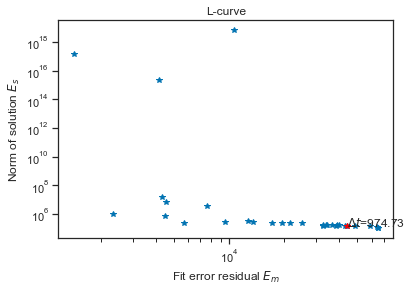

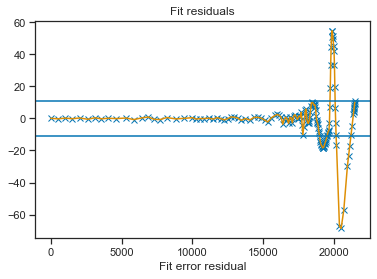

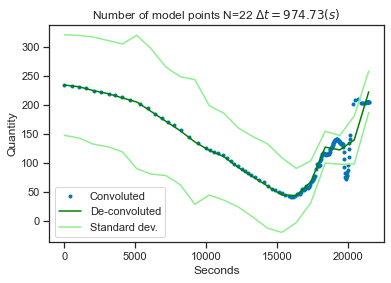

In [16]:
# get tau values from temperature
boundary_layer_thickness = 120
tau = bgc.lookup_tau(boundary_layer_thickness, temp)
k = 1/tau

# correct oxygen with Bittig method
bittig_corr = bgc.correct_response_time(time/60/60/24, obs, temp, boundary_layer_thickness)
# correct with Dolvan method
u_a_est, u_m_est, t_model, u_a_std, resid = deconv(obs, time, k[0], sigma=data.DOXY.std()*np.ones(time.shape))
# get pressure from t_model
f = interp1d(time, pres)
p_model = f(t_model)

(520.0, -20.0)

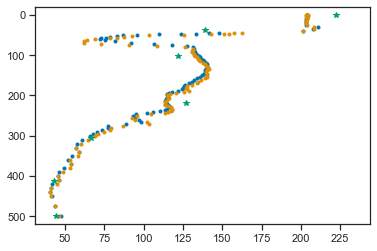

In [17]:
fig, axes = plt.subplots()
axes.plot(obs, pres, '.', label='Raw Data')
axes.plot(bittig_corr, pres, '.', label='Bittig Correction')
axes.plot(u_a_est, p_model, '*', label='Dolvan Correction')
axes.set_ylim((520,-20))